# ВВП Ганы

In [88]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook')
# sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 8)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

### Загрузка данный и первичный анализ

In [89]:
df = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col='year')
df.columns = ['GDP']
df.index.freq = 'YS'
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Freq: AS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


In [90]:
df

,GDP
year,
1960-01-01,1217086834.73
1961-01-01,0.00
1962-01-01,1382352941.18
1963-01-01,1540616246.50
1964-01-01,1731092436.97
...,...
2017-01-01,60406382898.52
2018-01-01,67299280679.56
2019-01-01,68337537815.77


In [91]:
df[df['GDP'] == 0]

,GDP
year,
1961-01-01,0.00


В данных есть пропуск в виде нулевого значения. Понятно что ВВП не мог быть нулевым. Логично заполнить этот пропуск средним значением по годам до и после пропусков.

In [92]:
df['GDP'] = df['GDP'].replace(0, np.nan)
df['GDP'] = df['GDP'].interpolate(method='linear')


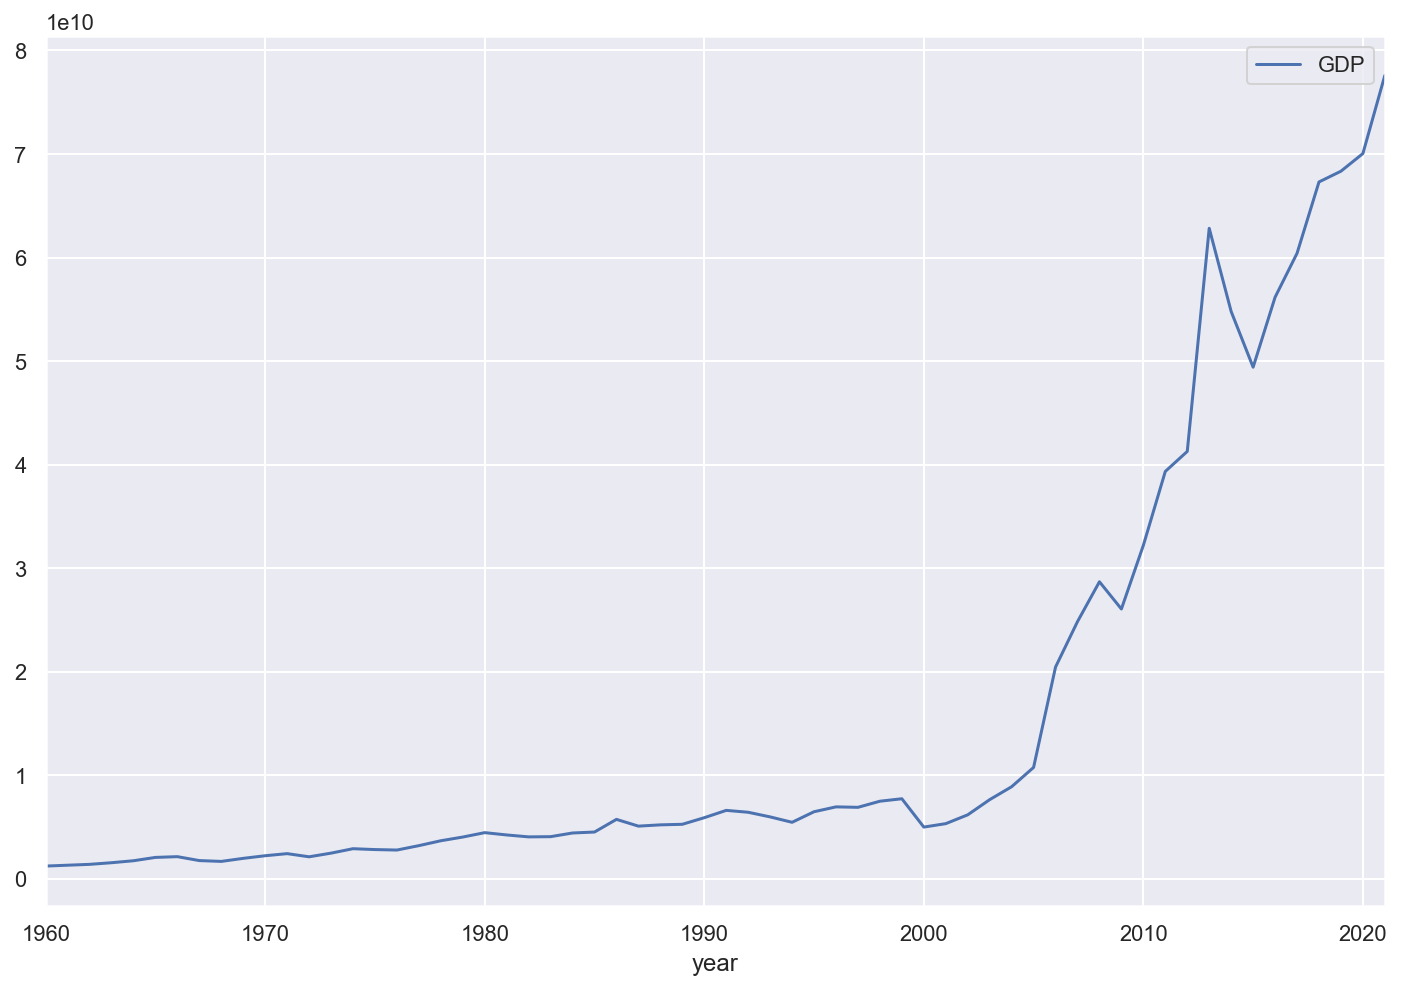

In [93]:
df.plot();

На графике виден экспоненциальный рост

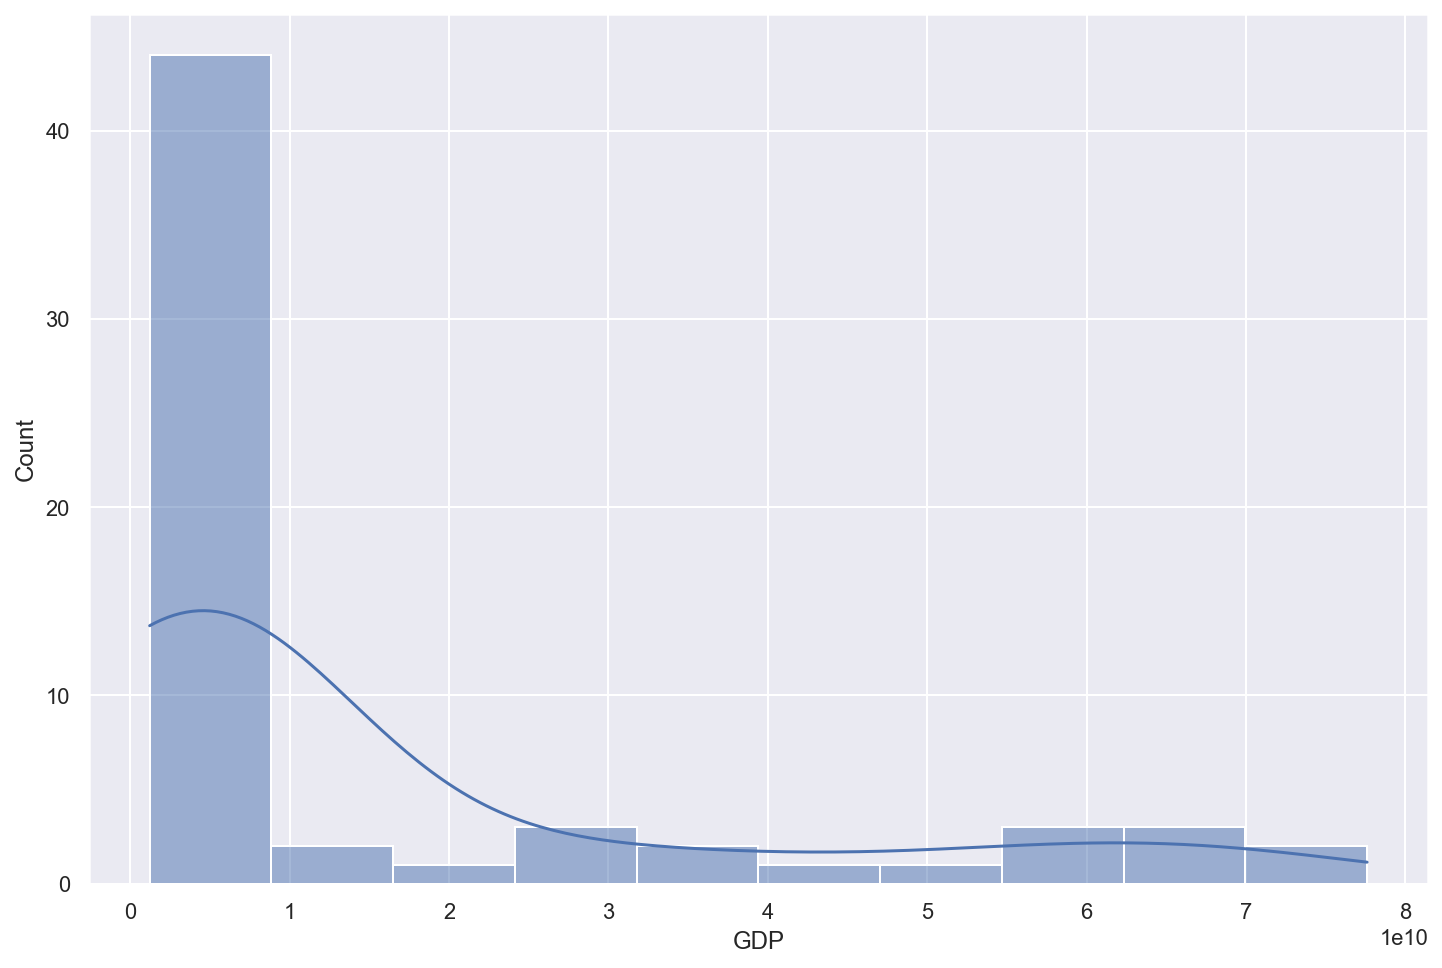

In [94]:
sns.histplot(df['GDP'], kde=True);

Распределение похоже на лог-нормальное

### Произвожу декомпозицию

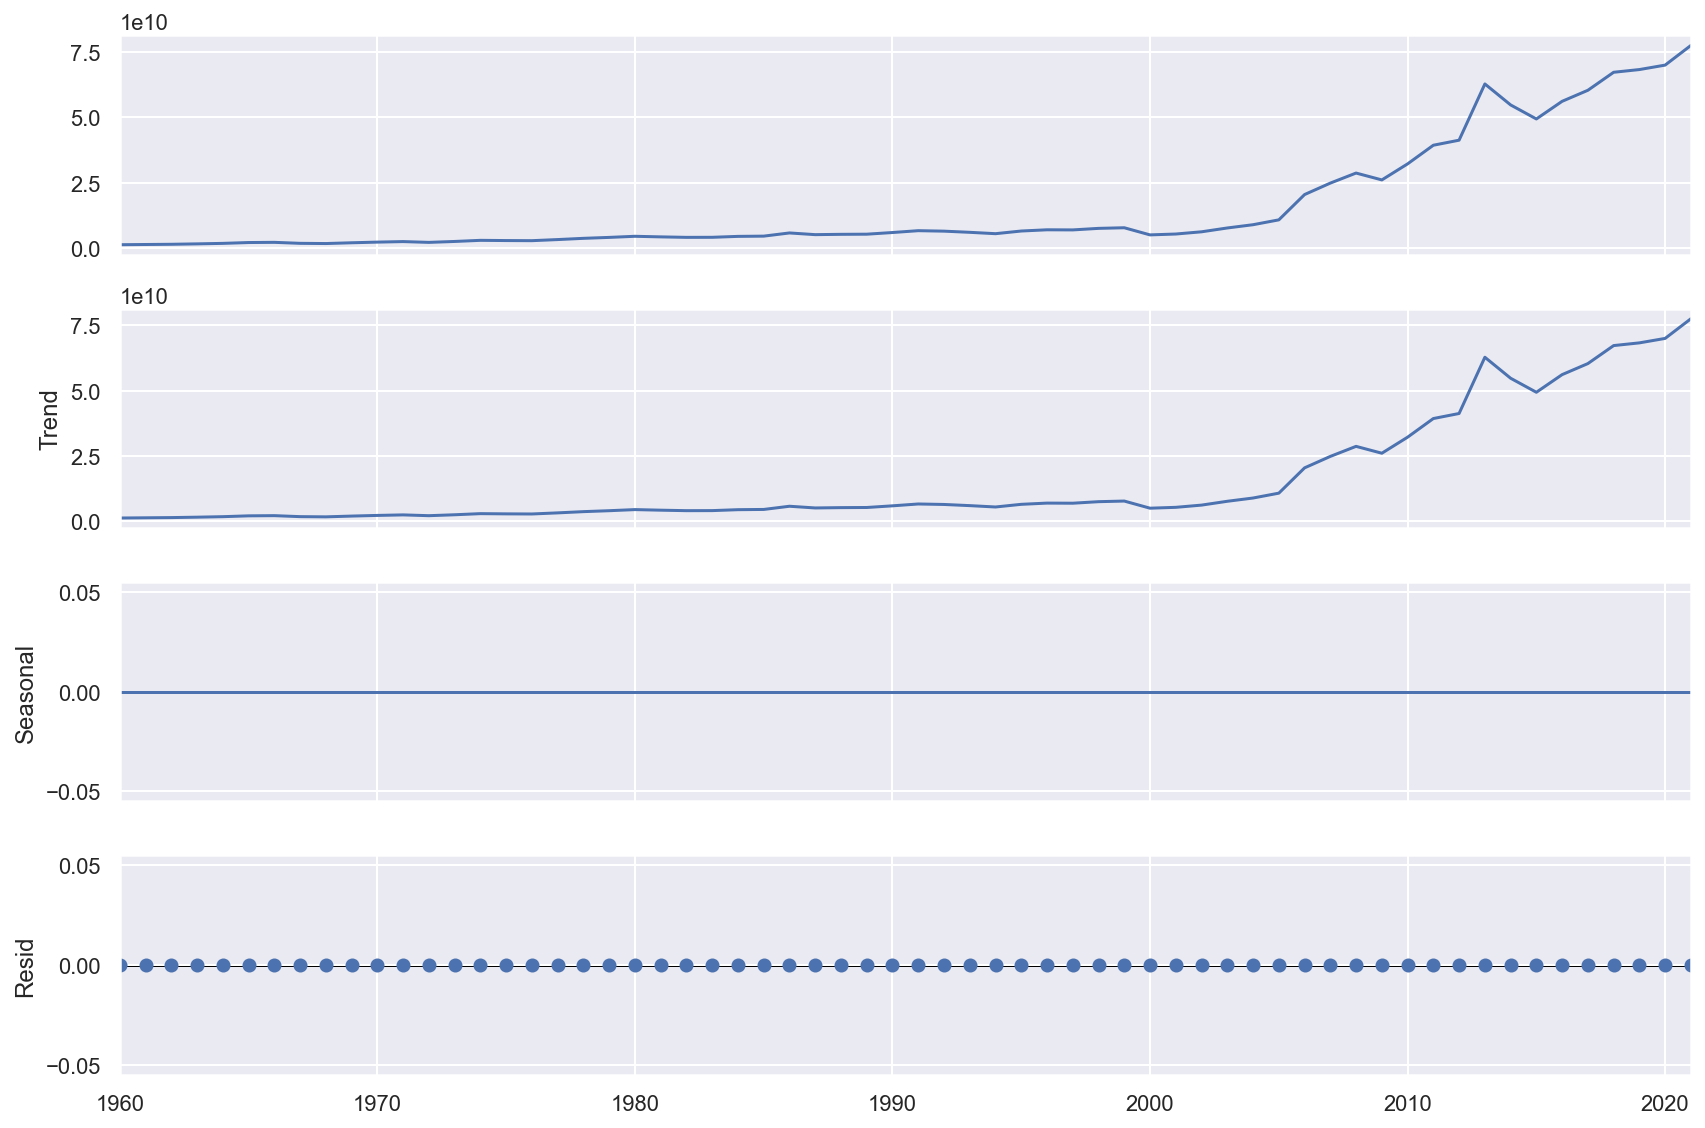

In [95]:
decomposition = seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

- Трендовая компонента не сильно отличается от исходного ряда, тренд есть
- Сезонная компонента отсутствует
- Шум нулевой, что странно

# Разделение выборки

In [96]:
test_period = 3 # последние три года оставляю для теста
train_df, test_df = df.iloc[:-test_period].copy(), df.iloc[-test_period:].copy()

### Визуализация MA
Строю 3х летний краткосрочный цикл и 10ти летний долгосрочный

In [97]:
df['ma_3'] = df['GDP'].rolling(3).mean()
df['ma_10'] = df['GDP'].rolling(10).mean()

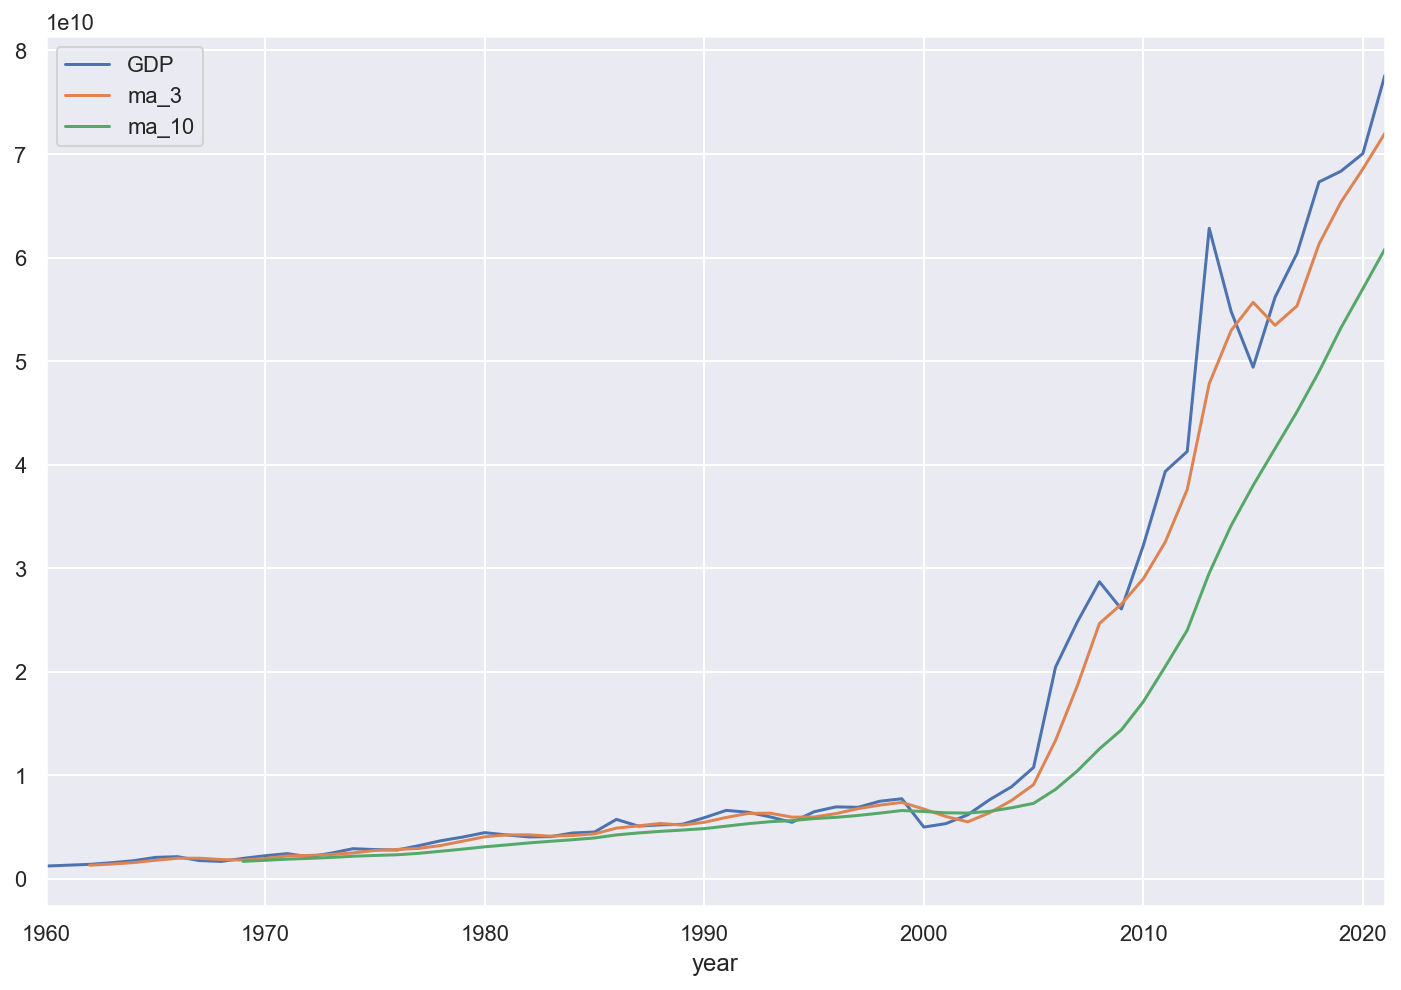

In [98]:
df.plot();

# Проверка стационарности

In [106]:
def adf(x, threshold=0.05):
    """
    Тест стационарности Augmented Dickey-Fuller Test(ADF Test)

    Args:
        x: Вектор значений переданный для проверки на стационарность
        threshold: Уровень достоверности, по умолчанию 5%

    Returns:
    """

    _, pvalue = adfuller(x)[0], adfuller(x)[1]

    print('Test-Statistic:', _)
    print('P-Value:', pvalue)

    # The null hypothesis of the ADF test is that the time series is non-stationary.
    H0 = 'Time series is non-stationary'
    Ha = 'Time series is stationary!'

    if pvalue <= threshold: # Reject the null hypothesis
        print(Ha)
    else:
        print(H0)

In [107]:
adf(train_df['GDP'])

Test-Statistic: 0.8030073326980115
P-Value: 0.9916845572455877
Time series is non-stationary


Ряд не стационарен, дифференцирую

In [112]:
train_df['GDP_diff1'] = train_df['GDP'].diff(2)
adf(train_df['GDP_diff1'].dropna())

Test-Statistic: -3.9998034409491487
P-Value: 0.0014115408436661348
Time series is stationary!


Дифференцирую второй раз

In [109]:
train_df['GDP_diff2'] = train_df['GDP_diff1'].diff()
adf(train_df['GDP_diff2'].dropna())

Test-Statistic: -2.6346347460078436
P-Value: 0.08604813722197652
Time series is non-stationary


Дифференцирую третий раз, ряд по прежнему нестационарен

In [110]:
train_df['GDP_diff3'] = train_df['GDP_diff2'].diff()
adf(train_df['GDP_diff3'].dropna())

Test-Statistic: -4.82560368730402
P-Value: 4.8573180767999755e-05
Time series is stationary!


Ряд стал стационарным после третьего дифференцирования

Попробую логарифмировать цены

In [104]:
train_df['GDP_log'] = np.log(train_df['GDP'] + 1)
adf(train_df['GDP_log'])

Test-Statistic: 0.6246254709247598
P-Value: 0.9882071359973053
Time series is non-stationary


Либо было достаточно логарифимического преобразования